## Pre-processing
1. Data Prep for GroundTruth.csv (read_labels)
    - Read in CSV File
    - Reverse One-Hot Encoding
    - Add .jpg for Image files
2. Split Data into Test/Train/Validate (split_data)
    - 80% train, 10% test, 10% validate
3. Balance Classes in Datasets (get_balanced_df)
    - Sample data based on Class - Stratification
    - Add weights for Classes if unequal
    - https://machinelearningmastery.com/data-sampling-methods-for-imbalanced-classification/ 
    - https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
4. Read in Images
    - 

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import warnings
warnings.filterwarnings('ignore')

# Image Pre-processing
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import block_reduce
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def read_labels(data_path = 'data/archive/'):
    """Function to read in the .csv file 'GroundTruth' and reverse the one-hot encoding that was applied.
    (Should be better for classification algorithms?)
    Args:
        data_path (str, optional): Path of .csv file. Defaults to 'data/archive/'.
    Returns:
        Pandas df: two column pandas dataframe - image name and cancer type
    """

    # read in csv file
    df = pd.read_csv(f'{data_path}GroundTruth.csv')
    df['image'] = df['image'] + '.jpg' # adds filetype to image column

    # get list of categories
    categories = df.columns.values.tolist()
    categories.remove('image')

    # reverse the one-hot encoding
    new_col = df[categories].idxmax(1)
    new_col = pd.DataFrame(new_col, columns = ['cancer_type'])
    df = pd.concat([df['image'], new_col], axis = 1)
    
    return df


df = read_labels('data/')
print(df.head())

              image cancer_type
0  ISIC_0024306.jpg          NV
1  ISIC_0024307.jpg          NV
2  ISIC_0024308.jpg          NV
3  ISIC_0024309.jpg          NV
4  ISIC_0024310.jpg         MEL


In [3]:
def split_data(df, train_pct=0.80):
    """Function to split data into train, test, and validate datasets.
    Args:
        df (DataFrame, required): Data to split
        train_pct (float, optional): Percentage of train split
    Returns:
        3 DataFrames: randomly sampled data, size based on percentage 
    """ 
    train, remaining = train_test_split(df, train_size=train_pct, shuffle=True, random_state=1)
    test, validate = train_test_split(remaining, train_size=0.50, shuffle=True, random_state=1)
    
    print('Train Size: ', len(train.index))
    print('Test Size: ', len(test.index))
    print('Validate Size: ', len(validate.index))
    
    return train, test, validate


# 80% train, 10% test, 10% validate
train_df, test_df, validate_df = split_data(df)

Train Size:  8012
Test Size:  1001
Validate Size:  1002


In [4]:
def get_balanced_df(df, val_size=350, col='label'):
    """Function to balance dataset based on Class and add Weight.
    Args:
        df (DataFrame, required): Data to split
        val_size (int, optional): Sample size for each value in class
        col (str, optional): Column for class balance
    Returns:
        DataFrame: balanced DataFrame based on class and weight.
    """
    balanced = []
    for val in train_df[col].unique():
        label_i = train_df[train_df[col] == val]
        if len(label_i.index) >= val_size:
            label_i = label_i.sample(val_size)
            weight_i = 1.0
        else:
            weight_i = val_size/len(label_i.index)
        label_i['class_weight'] = weight_i
        balanced.append(label_i)
        
    balanced_df = pd.concat(balanced)
    return balanced_df

train_df2 = get_balanced_df(train_df, col='cancer_type')
train_df2.groupby(['cancer_type','class_weight']).agg(['count'])

,,image
,,count
cancer_type,class_weight,
AKIEC,1.377953,254
BCC,1.000000,350
BKL,1.000000,350
DF,3.846154,91
MEL,1.000000,350
NV,1.000000,350
VASC,2.966102,118


In [5]:
def get_imgs(img_dir='data/images/*'):
    imgs = glob.glob(img_dir)
    return imgs
    
    
def read_img(img_path):
    img = plt.imread(img_path)
    #print('Image Shape: ', img.shape)
    return img
    
    
def plot_img(img):
    plt.imshow(img)

    
def downsample_img(img, size=(2, 2, 1)):
    img_array = block_reduce(img[:, :], size, np.mean)
    #print(img.shape, ' -> ', img_array.shape)
    return img_array


def reshape_img(img, scale=4):
    img_resized = resize(img, (img.shape[0] // scale, img.shape[1] // scale), anti_aliasing=True)
    #print('Image Resized: ', img.shape, ' -> ', img_resized.shape)
    return img_resized


def get_img_generator(df, img_dir=r'data/images/', x='image', y='cancer_type', h=112, w=150, batch=50):
    gen = ImageDataGenerator()
    gen_data = gen.flow_from_dataframe(df, img_dir, x_col=x, y_col=y, target_size=(h, w), batch_size=batch,
                                        class_mode='categorical') #, color_mode='rgb'
    return gen_data


## Normal Image

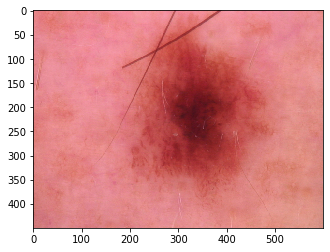

In [6]:
images = get_imgs(img_dir='data/images/*')

img = read_img(img_path=images[6147])
plot_img(img)

## Resahped Image

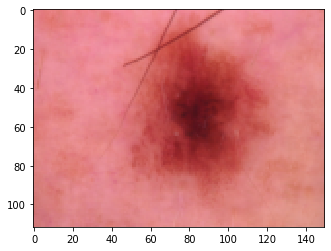

In [7]:
img2 = reshape_img(img)
plot_img(img2)

## Resahped Image (TensorFlow Image Generator)

In [8]:
train_gen = get_img_generator(df, batch=len(df.index))
images_gen, labels_gen = next(train_gen)

Found 10015 validated image filenames belonging to 7 classes.


'ISIC_0030453.jpg'

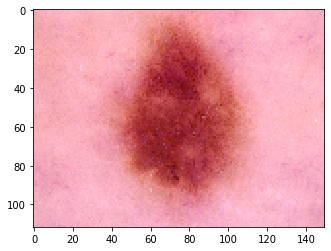

In [9]:
plot_img(images_gen[6147]/255)
train_gen.filenames[6147]

In [16]:
x_imgs = [read_img('data/images/'+img) for img in train_df['image']] 
x_train = [reshape_img(img) for img in x_imgs] 
y_train = [label for label in train_df['cancer_type']]

In [17]:
print(x_train1[0].shape)
print(x_train2[0].shape)
print(y_train[0])

(450, 600, 3)
(112, 150, 3)
NV
